## Imports

In [15]:
from chord_geometry_int import ChordGeometryInterferometry
from magnetic_equilibrium import MagneticEquilibrium, MagneticEquilibriumSinglePoint
from interferometry import Interferometry, InterferometrySinglePoint
from density_profile import DensityProfile, DensityProfileSinglePoint
from forward_1d_triangle_int import compute_response_matrix, plot_geometry_with_mag_equi
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize, basinhopping
import optuna

%matplotlib inline

## Load data (of a single time slice)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


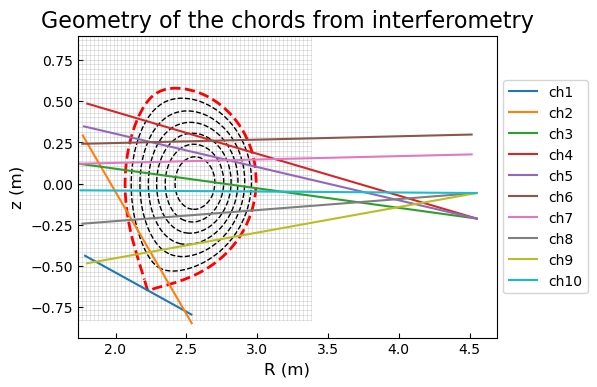

In [3]:
shot = 53259 # Shot number
t = 5.21    # Time (relative to the start of plasma)

# Geometry of the chords from interferometer (lines of sight)
geo = ChordGeometryInterferometry(f'data/WEST/{shot}/los_interferometer_{shot}.mat')

# Magnetic equilibrium calculated by equilibrium code NICE
equi_all = MagneticEquilibrium()
equi_all.load_from_imas(f'data/WEST/{shot}/imas_equilibrium_{shot}.mat', shot=shot)
equi = equi_all.get_single_point(t)

# Line integrated electron density measured by interferometer
interf_all = Interferometry()
interf_all.load_from_imas(f'data/WEST/{shot}/imas_interferometer_{shot}.mat', shot=shot)
interf = interf_all.get_single_point(t)

# Density profile calculated by equilibrium code NICE
dens_prof_all = DensityProfile()
dens_prof_all.load_from_imas(f'data/WEST/{shot}/imas_core_profiles_{shot}.mat', shot=shot)
dens_prof = dens_prof_all.get_single_point(t)

plot_geometry_with_mag_equi(geo, equi)

In [20]:
def chol_inv(A):
    L = np.linalg.cholesky(A)
    return np.linalg.inv(L).T @ np.linalg.inv(L)
def chol_det(A):
    L = np.linalg.cholesky(A)
    return np.prod(np.diag(L))

      fun: 0.295978209880035
 hess_inv: array([[ 0.03652937, -0.00620105],
       [-0.00620105,  0.00108964]])
      jac: array([-1.04308128e-05, -3.89814377e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 277
      nit: 21
     njev: 90
   status: 2
  success: False
        x: array([-6.5302225 ,  1.71049983])


Not good if zero, as need to be chol_inverted.
The Determinent of K is: 0.0
The Determinent of cov_li is: 1.0000000000000006e-10
The Determinent of cov_post3 is: 0.0


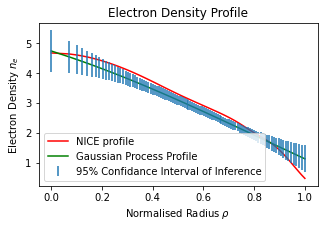

In [24]:
##Prior
exp_er = 0.01
rho_1d = dens_prof.rho_tor_norm_1d
N = len(rho_1d)
mu_prior = np.zeros(N)
lid_data = interf.lid.compressed()
#exponential square kernel
def Kernel(rho1,rho2,params):
    #amplitude determins how far the model can go from the mean
    amp = params[0]
    #length scale determines smoothness, how correlated the function should be at a distance
    l = params[1]
    return amp**2 * np.exp(-((rho1-rho2)*(rho1-rho2))/(2*l**2))

def KRcov_li(params,trial_exp_er):
    rho1, rho2 = np.meshgrid(rho_1d,rho_1d)
    #covergence matrix of Prior
    K = Kernel(rho1,rho2,params)
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    K[np.diag_indices_from(K)] += 1e-8 
    #covergence matrix of Likelyhood
    cov_li = np.diag(np.repeat(trial_exp_er,10))
    R = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)
    return K, R, cov_li

def MargLi(params):
    K, R, cov_li = KRcov_li(params,exp_er)
    invertable = cov_li + R @ K @ R.T
    #add a small term onto diagonal of matricies to be inverted.
    #this ensures it is positive definate and cholensky matrix can be computed
    invertable[np.diag_indices_from(invertable)] += 1e-8 
    return 0.5*np.log(chol_det(cov_li + R@K@R.T)) + 0.5*(lid_data.T@chol_inv(cov_li+R@K@R.T)@lid_data)                
    
x0=[0.76,0.01]
results = minimize(MargLi, x0=x0)
# results = basinhopping(MargLi, x0=x0, niter=100)
print(results)
best_params = results.x
# best_params = x0

def PlotBest(params,trial_exp_er): 
    K, R, cov_li = KRcov_li(params,trial_exp_er)
#     print(K)
    cov_post3 = chol_inv(R.T @ chol_inv(cov_li) @ R + chol_inv(K))
    mu_post3 = mu_prior + cov_post3 @ R.T @ chol_inv(cov_li) @ (lid_data - R @ mu_prior)
    error_bars3 = 1.96*np.sqrt(np.diagonal(cov_post3))

    print('\n\nNot good if zero, as need to be chol_inverted.')
    print('The Determinent of K is:', chol_det(K))
    print('The Determinent of cov_li is:', chol_det(cov_li))
    print('The Determinent of cov_post3 is:', chol_det(cov_post3))

    figGPR3 = plt.figure(figsize=(5,3))
    plt.title('Electron Density Profile')
    plt.xlabel(r'Normalised Radius $\rho$')
    plt.ylabel(r'Electron Density $n_e$')
    plt.plot(rho_1d, dens_prof.dens_1d,'r', label='NICE profile')
    plt.plot(rho_1d, mu_post3,'g', label='Gaussian Process Profile')
    plt.errorbar(rho_1d, mu_post3, yerr=error_bars3, label='95% Confidance Interval of Inference', fmt='none')
    plt.legend()
    plt.show()

PlotBest(best_params, exp_er)

## Validation of the forward model

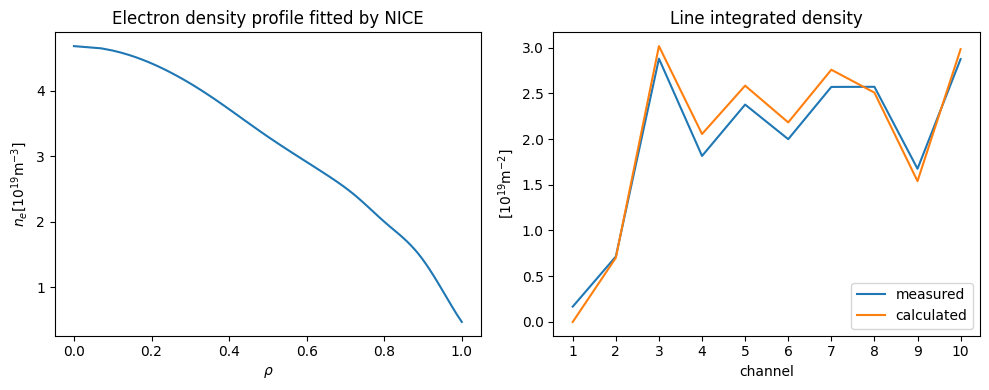

In [3]:
# The response matrix used for calculating line integrals
response = compute_response_matrix(geo, equi, dens_prof.rho_tor_norm_1d)



# Calculate the line integrated density using density profile fitted by NICE
lid_calculated = response @ dens_prof.dens_1d

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(dens_prof.rho_tor_norm_1d, dens_prof.dens_1d)
ax1.set_xlabel(r'$\rho$')
ax1.set_ylabel(r'$n_e[\mathrm{10^{19} m^{-3}}]$')
ax1.set_title('Electron density profile fitted by NICE')

ax2.plot(interf.channels.compressed(), interf.lid.compressed(), label='measured')
ax2.plot(interf.channels.compressed(), lid_calculated, label='calculated')
ax2.set_xticks(interf.channels.data)
ax2.set_xlabel('channel')
ax2.set_ylabel(r'$[\mathrm{10^{19} m^{-2}}]$')
ax2.set_title('Line integrated density')
ax2.legend()
plt.tight_layout()